In [371]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import keras
from keras import layers
from keras.callbacks import EarlyStopping

import tensorflow as tf

In [372]:
# check GPU
from tensorflow.python.client import device_lib
display(tf.config.list_physical_devices("GPU"))
display(device_lib.list_local_devices())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

I0000 00:00:1752130095.609431    8622 gpu_device.cc:2019] Created device /device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:10:00.0, compute capability: 8.9


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15174570653335819260
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5833228288
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5525595496043096834
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:10:00.0, compute capability: 8.9"
 xla_global_id: 416903419]

In [373]:
data_file_path = "../datasets/ionosphere/"

In [374]:
# setup plotting
# display(plt.style.available)
plt.style.use("seaborn-v0_8-whitegrid")
# setup defaults
plt.rc("figure", autolayout = True)
plt.rc("axes", labelweight = "bold", labelsize = "large",
       titleweight = "bold", titlesize = 18, titlepad = 10)

In [375]:
ionosphere_data = pd.read_csv("../datasets/ionosphere/ion.csv")
display(ionosphere_data.head())

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V26,V27,V28,V29,V30,V31,V32,V33,V34,Class
0,1,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,good
1,2,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,bad
2,3,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,good
3,4,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,bad
4,5,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,good


In [376]:
df = ionosphere_data.copy()

# good = 1; bad = 0
df["Class"] = df["Class"].map({"good" : 1,
                               "bad" : 0,})

display(df.head())

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V26,V27,V28,V29,V30,V31,V32,V33,V34,Class
0,1,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,1
1,2,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,0
2,3,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,1
3,4,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,0
4,5,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,1


In [377]:
# split data
df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

# normalize
# max_ = df_train.max(axis=0)
# min_ = df_train.min(axis=0)
# df_train = (df_train - min_) / (max_ - min_)
# df_valid = (df_valid - min_) / (max_ - min_)

# drop column V2
df_train.dropna(axis=1, inplace=True)
df_valid.dropna(axis=1, inplace=True)

# create training data
X_train = df_train.drop("Class", axis=1)
X_valid = df_valid.drop("Class", axis=1)
y_train = df_train["Class"]
y_valid = df_valid["Class"]

display(X_train)
display(max(X_train.index))

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34
6,7,1,0,0.97588,-0.10602,0.94601,-0.20800,0.92806,-0.28350,0.85996,...,0.22792,-0.81634,0.13659,-0.82510,0.04606,-0.82395,-0.04262,-0.81318,-0.13832,-0.80975
52,53,1,0,1.00000,1.00000,1.00000,1.00000,0.91010,1.00000,-0.26970,...,0.90014,-1.00000,1.00000,-1.00000,1.00000,-1.00000,1.00000,-0.34686,1.00000,0.34845
114,115,1,0,0.91353,0.81586,-0.72973,1.00000,-0.39466,0.55735,0.05405,...,-0.00003,0.00002,-0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
45,46,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,...,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,1.00000,1.00000,0.00000,0.00000,0.00000
106,107,1,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,1.00000,0.10976,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,59,1,0,1.00000,0.05812,0.94525,0.07418,0.99952,0.13231,1.00000,...,0.91667,0.22431,0.88423,0.23571,0.88568,0.22511,0.78324,0.29576,0.83574,0.31166
41,42,1,0,-1.00000,-1.00000,1.00000,1.00000,1.00000,-0.14375,0.00000,...,-1.00000,-1.00000,1.00000,-1.00000,-1.00000,-1.00000,1.00000,1.00000,0.00000,0.00000
14,15,1,0,1.00000,0.07380,1.00000,0.03420,1.00000,-0.05563,1.00000,...,1.00000,0.20033,1.00000,0.36743,0.95603,0.48641,1.00000,0.32492,1.00000,0.46712
155,156,1,0,0.72414,-0.01084,0.79704,0.01084,0.80000,0.00197,0.79015,...,0.72611,-0.01478,0.78041,0.00612,0.74089,-0.05025,0.82956,0.02956,0.79015,0.00788


350

In [378]:
model_keras_sequential = keras.Sequential(
    [
        keras.Input((X_train.shape[1],)),
        layers.BatchNormalization(),
        
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0),
        
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0),
        
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0),

        layers.Dense(1, activation="sigmoid"),
    ]
)

In [379]:
model_keras_sequential.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)

In [380]:
keras_sequential_early_stopping = EarlyStopping(
    patience=100,
    restore_best_weights=True,
)

history_keras_sequential = model_keras_sequential.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=1000,
    callbacks=[keras_sequential_early_stopping],
)

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - binary_accuracy: 0.6382 - loss: 0.6623 - val_binary_accuracy: 0.2476 - val_loss: 1.0571
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - binary_accuracy: 0.9390 - loss: 0.2014 - val_binary_accuracy: 0.2571 - val_loss: 0.9879
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - binary_accuracy: 0.9675 - loss: 0.1095 - val_binary_accuracy: 0.2667 - val_loss: 0.9529
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - binary_accuracy: 0.9756 - loss: 0.0781 - val_binary_accuracy: 0.2857 - val_loss: 0.9203
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - binary_accuracy: 0.9837 - loss: 0.0626 - val_binary_accuracy: 0.2762 - val_loss: 0.8853
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - binary_accuracy: 0.9837 - loss: 0.0521 - val_binary_accuracy: 0.3143 - val_loss: 0.8483
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - binary_accuracy: 0.9837 - loss: 0.0432 - val_binary_accuracy: 0.3810 - val_loss: 0.8100
Epoch 8/1000
1/

'val_binary_accuracy: 0.9428571462631226'

'val_loss: 0.14523720741271973'

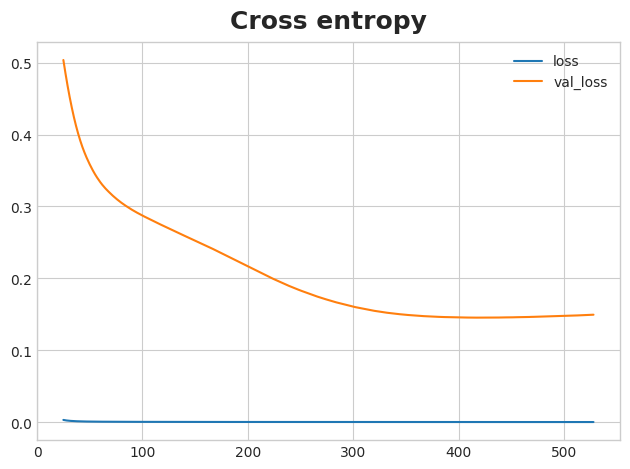

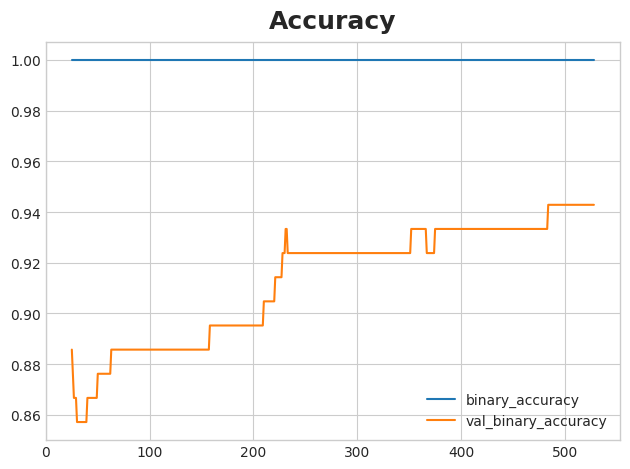

In [385]:
history_keras_sequential_df = pd.DataFrame(history_keras_sequential.history)
history_keras_sequential_df.loc[25:, ["loss", "val_loss"]].plot(title="Cross entropy")
history_keras_sequential_df.loc[25:, ["binary_accuracy", "val_binary_accuracy"]].plot(title="Accuracy")
display(f"val_binary_accuracy: {max(history_keras_sequential_df["val_binary_accuracy"])}")
display(f"val_loss: {min(history_keras_sequential_df["val_loss"])}")